# Run STitch3D on the human heart dataset

In this tutorial, we show STitch3D's analysis of the 6.5 PCW human embryonic heart dataset.

The spatial transcriptomics data are available from https://data.mendeley.com/datasets/dgnysc3zn5/1. The human embryonic heart dataset profiled by 10x Genomics Chromium platform is available at https://data.mendeley.com/datasets/mbvhhf8m62/2.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
import os
import sys

import STitch3D

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "8"

## Preprocessing

### Load datasets

Load spatial transcriptomics datasets:

In [2]:
count = pd.read_csv("./data/Filtered/filtered_ST_matrix_and_meta_data/filtered_matrix.tsv",
                    sep="\t", index_col=0).T

meta = pd.read_csv("./data/Filtered/filtered_ST_matrix_and_meta_data/meta_data.tsv",
                   sep="\t", index_col=0)

genes_new = pd.read_csv("./genes_new.txt")
count.columns = list(genes_new.x.values)

count = count.loc[:, count.columns.notna()]

In [3]:
adata_st_list_raw = []

for i in range(1, 10):
    count_i = count[[loc.split("x")[0]==str(i+4) for loc in count.index]]
    count_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in count_i.index]
    meta_i = meta[[loc.split("x")[0]==str(i+4) for loc in meta.index]]
    meta_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in meta_i.index]

    loc_i = pd.read_csv("./data/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/spot_data-all-ST_Sample_6.5PCW_%d.tsv" % (i, i),
                       sep="\t")

    loc_i.index = [(str(loc_i.x.values[k]) + 'x' + str(loc_i.y.values[k])) for k in range(loc_i.shape[0])]
    loc_i = loc_i.loc[meta_i.index]

    img_i = imread('./data/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/ST_Sample_6.5PCW_%d_HE_small.jpg' % (i, i))

    adata_st_i = ad.AnnData(X = count_i.values)

    adata_st_i.obs = meta_i
    adata_st_i.obs['selected'] = loc_i['selected'].values
    adata_st_i.var.index = count_i.columns

    library_id = '0'
    adata_st_i.uns["spatial"] = dict()
    adata_st_i.uns["spatial"]['0'] = dict()
    adata_st_i.uns["spatial"]['0']['images'] = dict()
    adata_st_i.uns["spatial"]['0']['images']['hires'] = img_i
    adata_st_i.uns["spatial"]['0']['scalefactors'] = {'spot_diameter_fullres': 100,
                                                      'tissue_hires_scalef': 1.0,
                                                      'fiducial_diameter_fullres': 100,
                                                      'tissue_lowres_scalef': 1.0}

    adata_st_i.obsm['spatial'] = np.concatenate((loc_i['pixel_x'].values.reshape(-1, 1), 
                                                 loc_i['pixel_y'].values.reshape(-1, 1)), axis=1)
    
    adata_st_i.obsm['loc_use'] = np.concatenate((loc_i['x'].values.reshape(-1, 1), 
                                                 loc_i['y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obs['array_row'] = loc_i['y'].values
    adata_st_i.obs['array_col'] = loc_i['x'].values

    adata_st_i = adata_st_i[adata_st_i.obs['selected'].values != 0]
    adata_st_list_raw.append(adata_st_i.copy())

Load single-cell reference dataset:

In [4]:
count_ref = pd.read_csv("./data/Filtered/share_files/all_cells_count_matrix_filtered.tsv", 
                        sep='\t', index_col=0).T

meta_ref = pd.read_csv("./data/Filtered/share_files/all_cells_meta_data_filtered.tsv", 
                        sep='\t', index_col=0)

adata_ref = ad.AnnData(X = count_ref.values)
adata_ref.obs.index = count_ref.index
adata_ref.var.index = count_ref.columns
for col in meta_ref.columns[:-1]:
    adata_ref.obs[col] = meta_ref.loc[count_ref.index][col].values

### Alignment of ST tissue slices

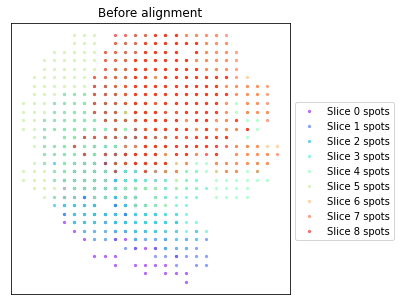

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


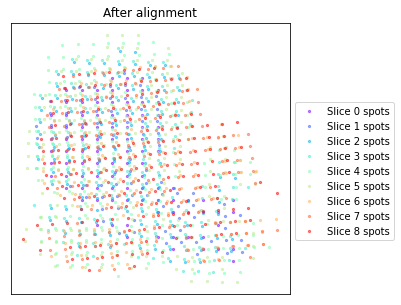

In [5]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw, data_type = "ST", coor_key="loc_use", test_all_angles=True, plot=True)

### Selecting highly variable genes and building 3D spatial graph

In [6]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list, 
                                                  adata_ref, 
                                                  sample_col="experiment",
                                                  rad_cutoff=1.1, c2c_dist=200., coor_key="loc_use",
                                                  slice_dist_micron=[5., 115., 85., 160., 
                                                                     5., 160., 5., 155.,],
                                                  n_hvg_group=500)

Finding highly variable genes...
3837 highly variable genes selected.
Calculate basis for deconvolution...
2 batches are used for computing the basis vector of cell type <Atrial cardiomyocytes>.
2 batches are used for computing the basis vector of cell type <Capillary endothelium>.
2 batches are used for computing the basis vector of cell type <Cardiac neural crest cells >.
2 batches are used for computing the basis vector of cell type <Endothelium / pericytes >.
2 batches are used for computing the basis vector of cell type <Epicardial cells>.
2 batches are used for computing the basis vector of cell type <Epicardium-derived cells>.
2 batches are used for computing the basis vector of cell type <Erythrocytes>.
2 batches are used for computing the basis vector of cell type <Fibroblast-like >.
1 batches are used for computing the basis vector of cell type <Immune cells>.
2 batches are used for computing the basis vector of cell type <Myoz2-enriched cardiomyocytes>.
1 batches are used fo

## Running STitch3D model

In [7]:
model = STitch3D.model.Model(adata_st, adata_basis)

model.train()

  0%|          | 6/20000 [00:00<19:06, 17.44it/s]  

Step: 0, Loss: 168.2983, d_loss: 162.5887, f_loss: 57.0959


 10%|█         | 2012/20000 [00:36<05:21, 55.94it/s]

Step: 2000, Loss: -1038.1444, d_loss: -1041.2513, f_loss: 31.0694


 20%|██        | 4010/20000 [01:11<04:44, 56.29it/s]

Step: 4000, Loss: -1057.3593, d_loss: -1060.2257, f_loss: 28.6640


 30%|███       | 6008/20000 [01:47<04:06, 56.79it/s]

Step: 6000, Loss: -1059.0846, d_loss: -1061.8103, f_loss: 27.2566


 40%|████      | 8007/20000 [02:23<03:33, 56.05it/s]

Step: 8000, Loss: -1061.1207, d_loss: -1063.7223, f_loss: 26.0159


 50%|█████     | 10011/20000 [02:59<02:56, 56.53it/s]

Step: 10000, Loss: -1061.6219, d_loss: -1064.1729, f_loss: 25.5094


 60%|██████    | 12007/20000 [03:34<02:23, 55.57it/s]

Step: 12000, Loss: -1062.2524, d_loss: -1064.7684, f_loss: 25.1594


 70%|███████   | 14011/20000 [04:10<01:47, 55.50it/s]

Step: 14000, Loss: -1062.5133, d_loss: -1065.0029, f_loss: 24.8968


 80%|████████  | 16009/20000 [04:46<01:11, 55.86it/s]

Step: 16000, Loss: -1062.3269, d_loss: -1064.8102, f_loss: 24.8331


 90%|█████████ | 18007/20000 [05:22<00:36, 54.79it/s]

Step: 18000, Loss: -1062.7762, d_loss: -1065.2416, f_loss: 24.6538


100%|██████████| 20000/20000 [05:58<00:00, 55.73it/s]


In [8]:
save_path = "./results_human_heart"

result = model.eval(adata_st_list_raw, save=True, output_path=save_path)

## Visualizing results in 2D

Slice 1


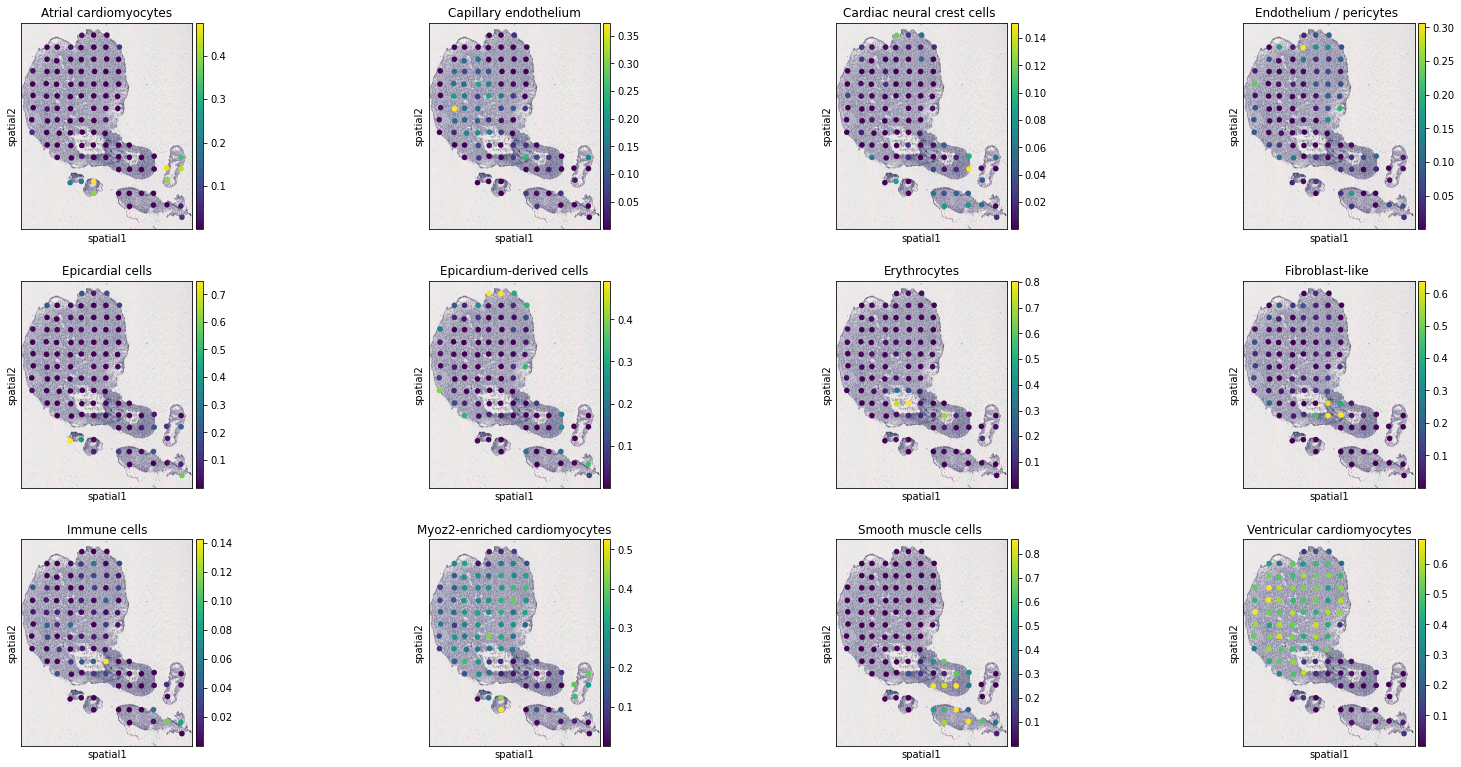

Slice 2


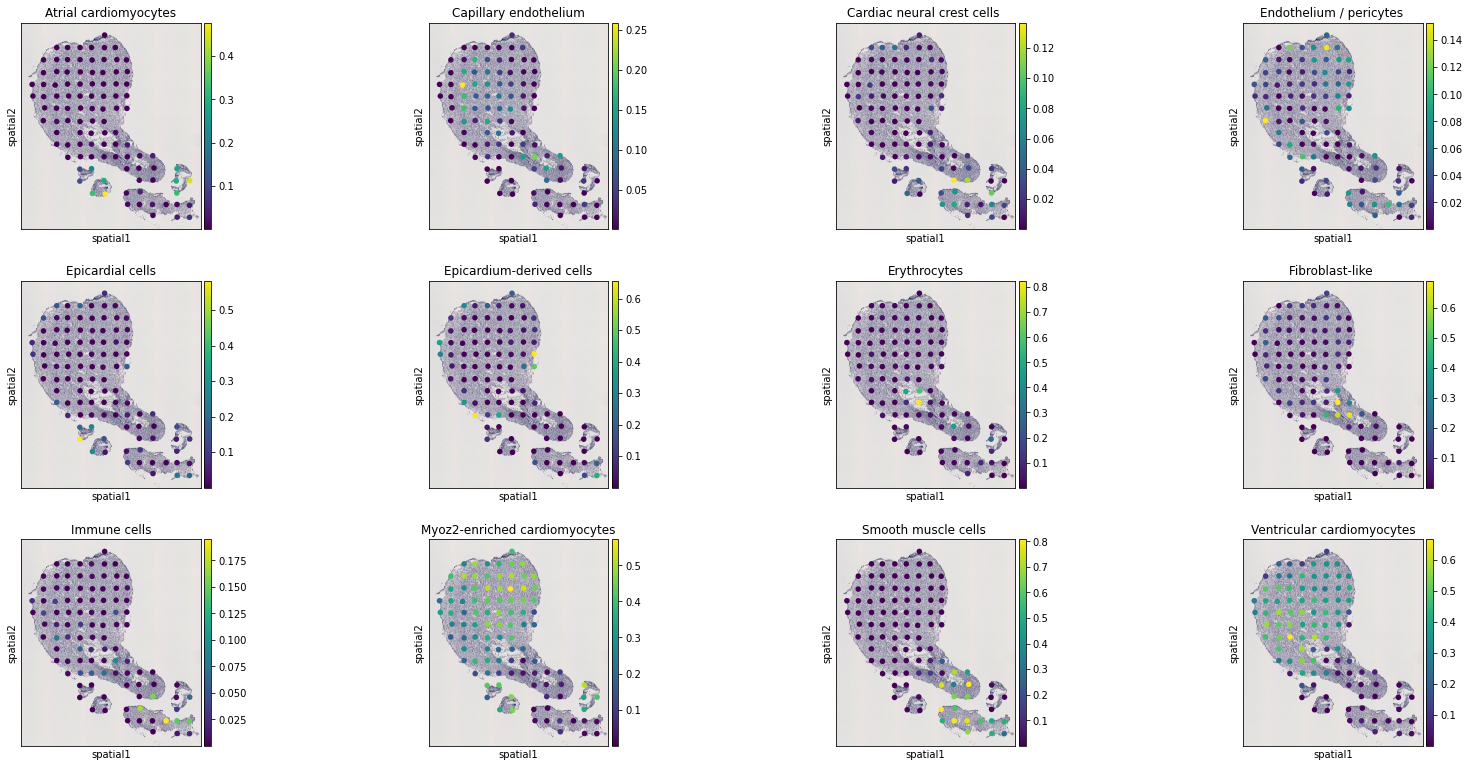

Slice 3


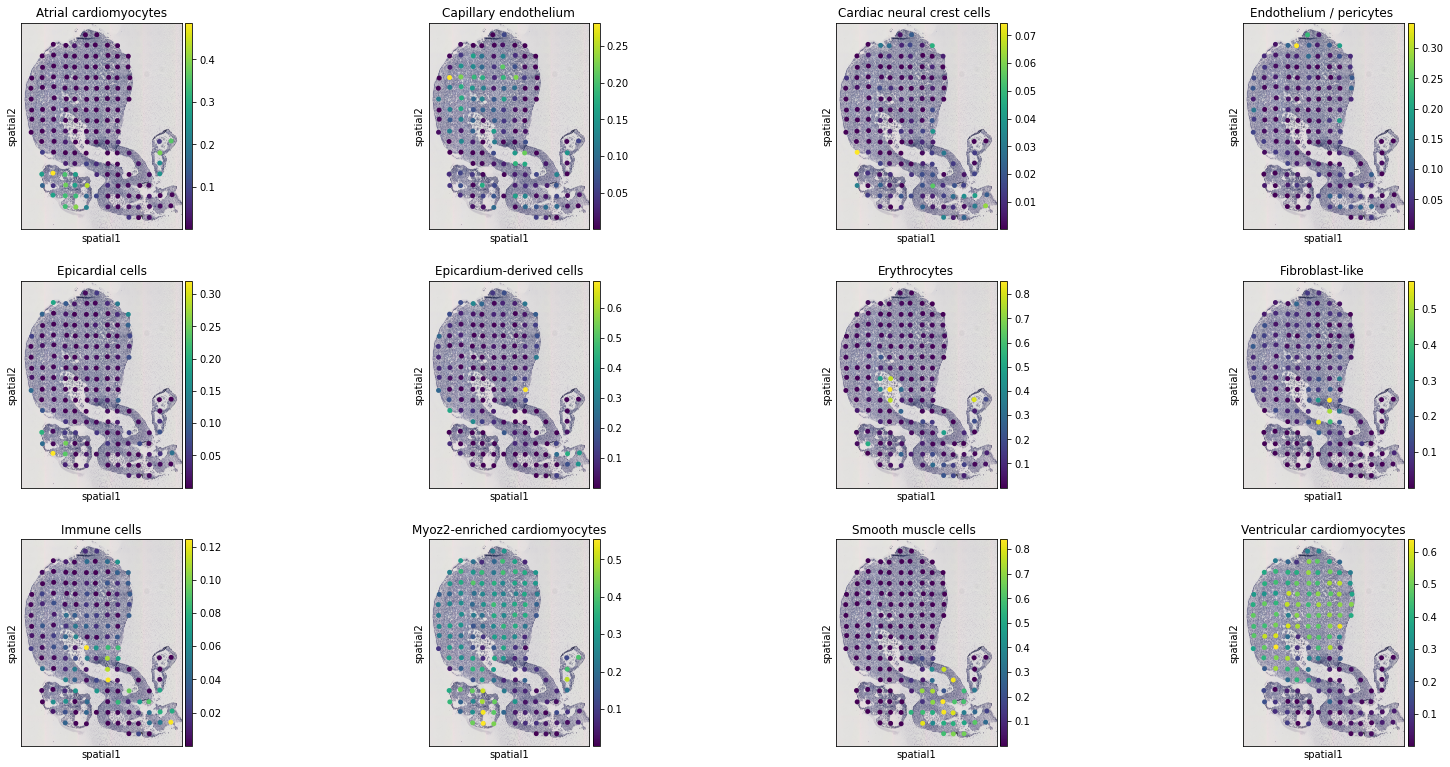

Slice 4


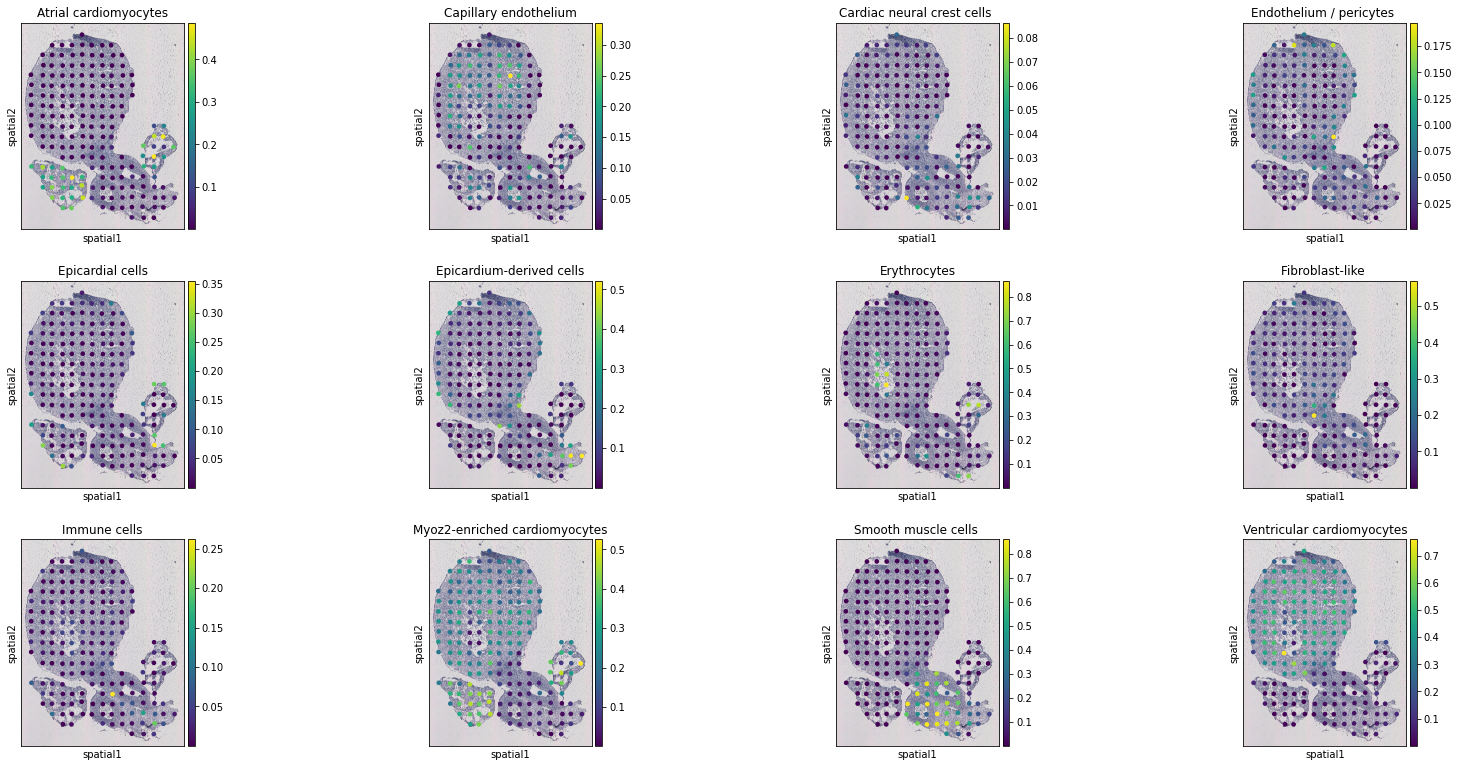

Slice 5


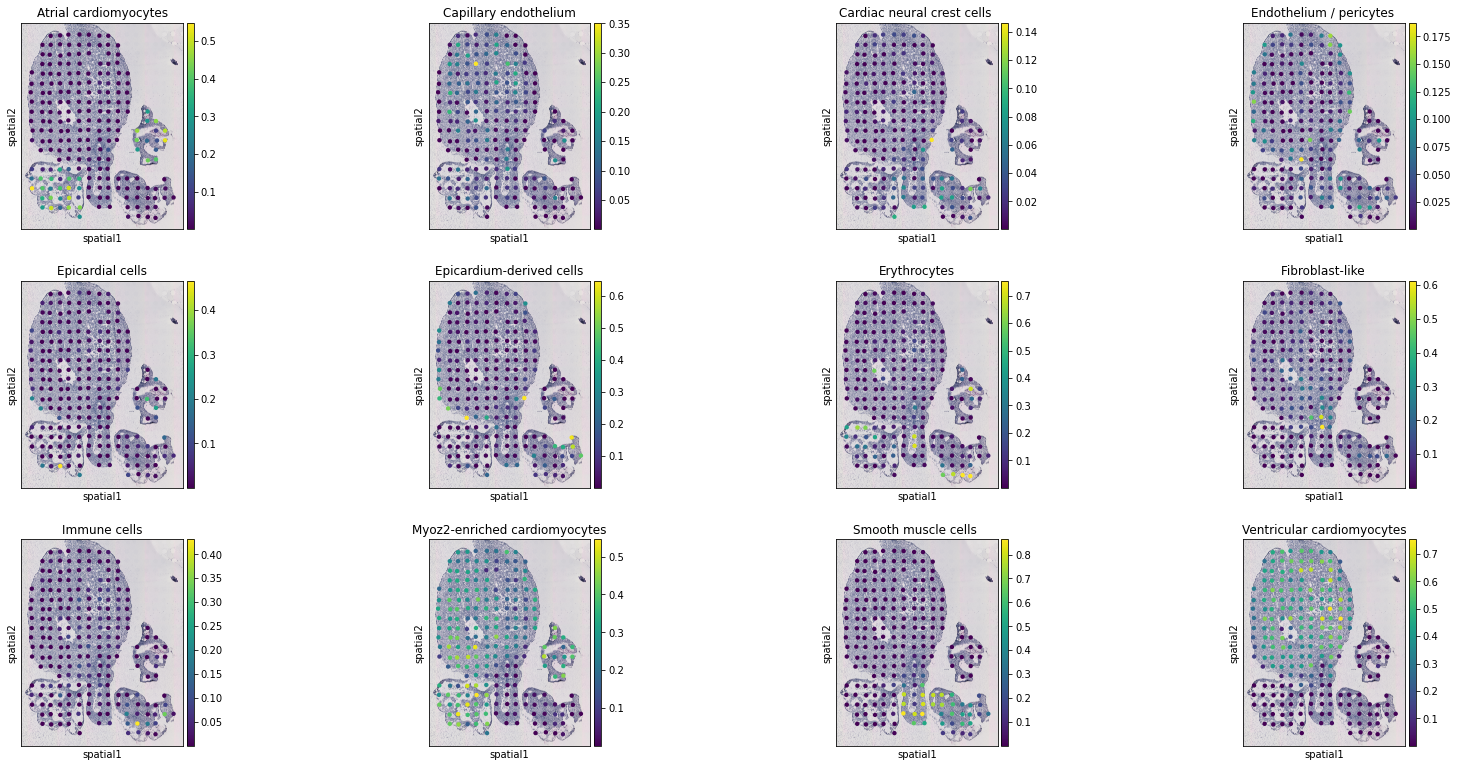

Slice 6


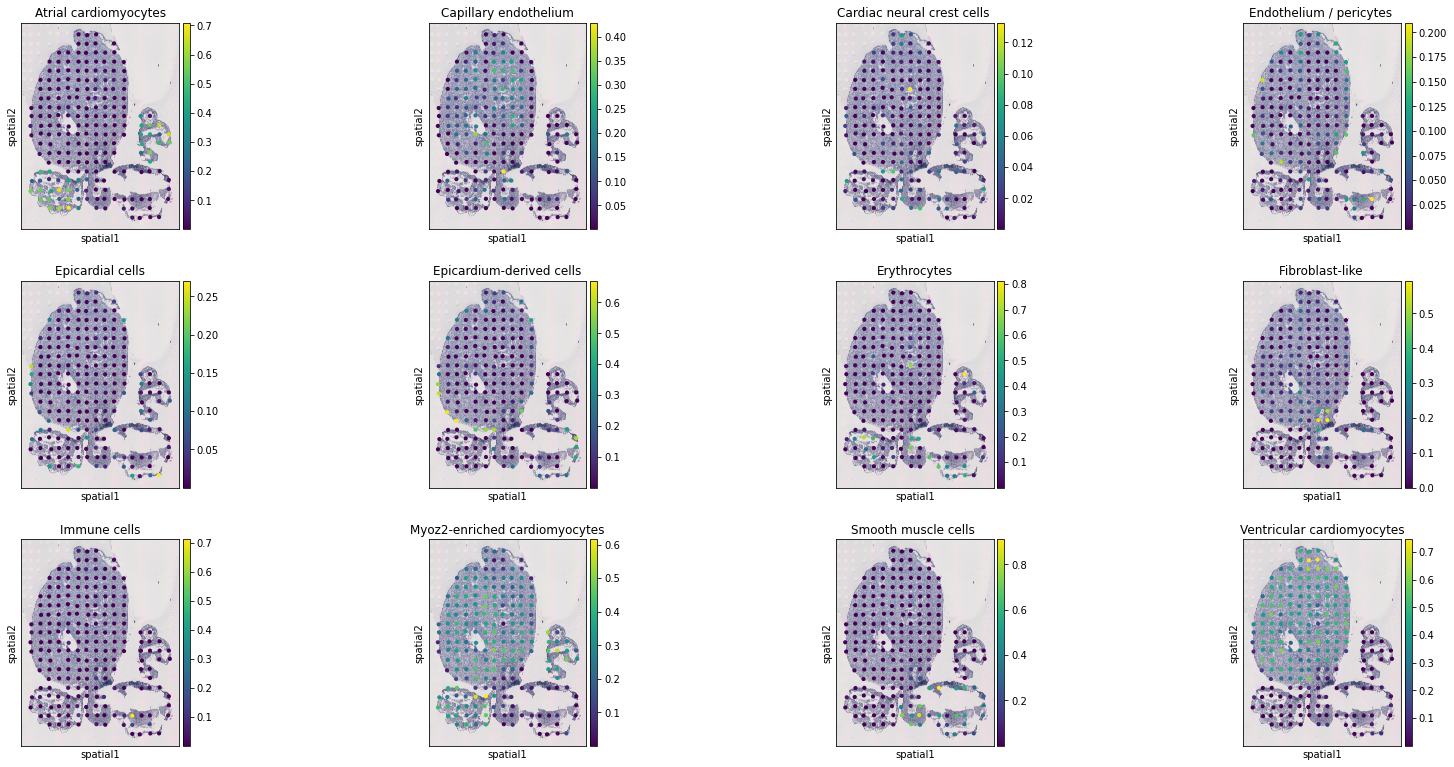

Slice 7


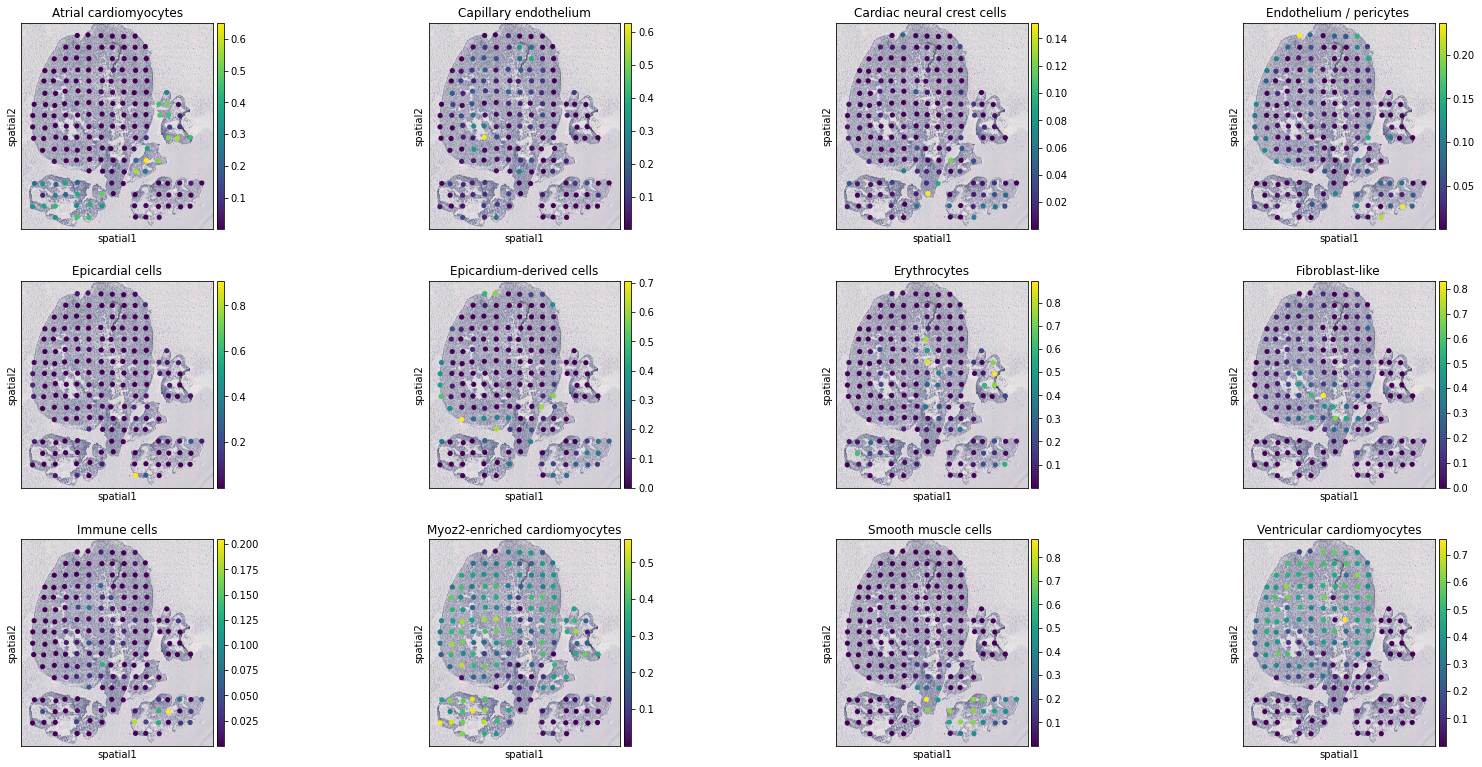

Slice 8


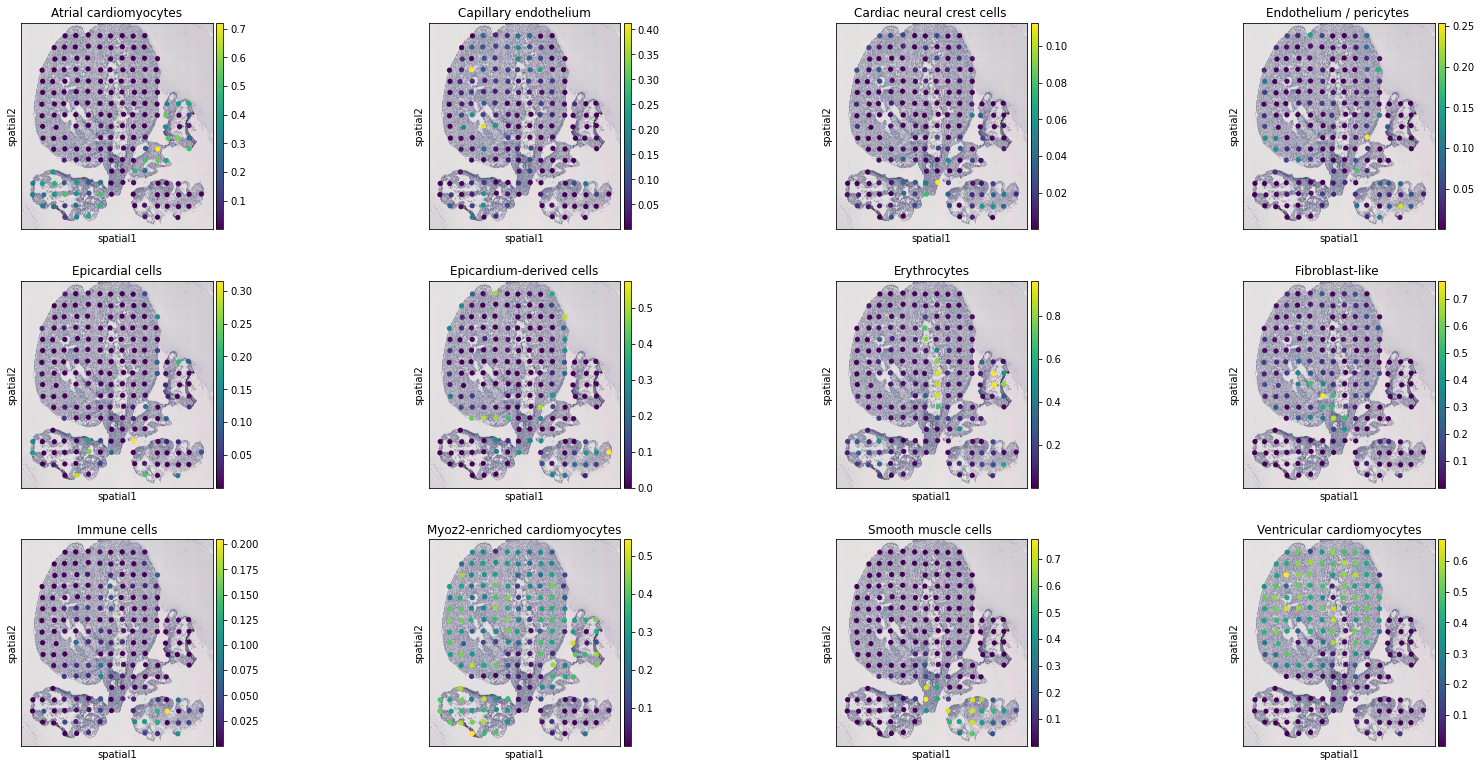

Slice 9


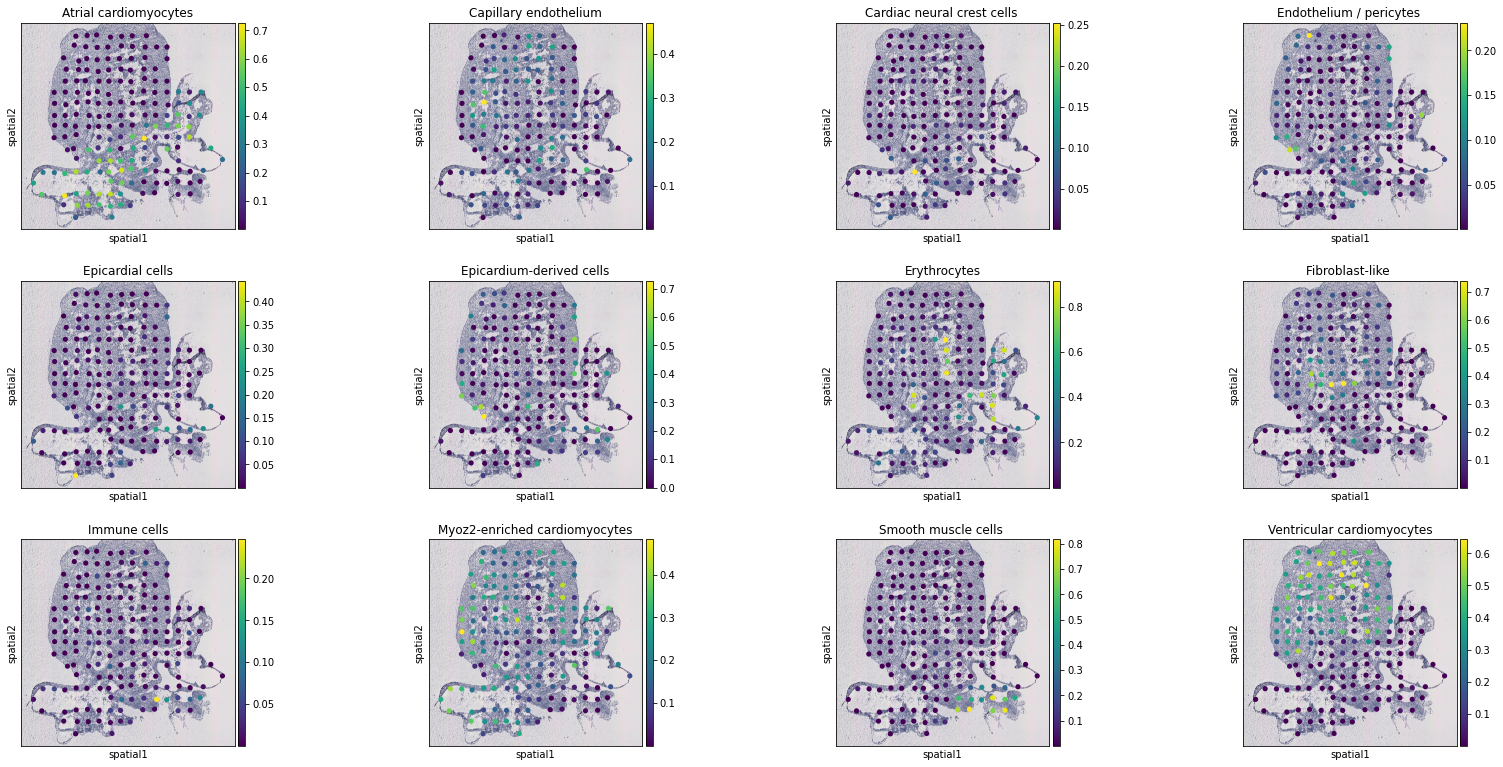

In [9]:
for i, adata_st_i in enumerate(result):
    print("Slice %d" % (i+1))
    sc.pl.spatial(adata_st_i, img_key="hires", color=model.celltypes, size=1.)

In [10]:
sc.pp.neighbors(model.adata_st, use_rep='latent', n_neighbors=30)
sc.tl.louvain(model.adata_st, resolution=0.5)

model.adata_st.obs["louvain"].to_csv(os.path.join(save_path, "clustering_result.csv"))

In [11]:
for i, adata_st_i in enumerate(result):
    adata_st_i.obs["louvain"] = model.adata_st.obs.loc[adata_st_i.obs_names, ]["louvain"]

In [12]:
color = ['#7570b3', '#1b9e77', '#d95f02', '#66a61e', '#e7298a']

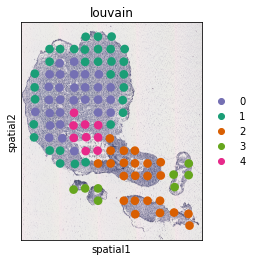

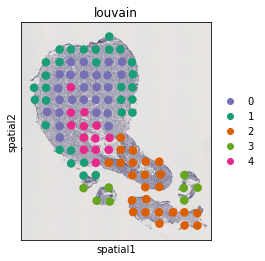

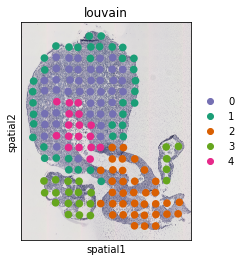

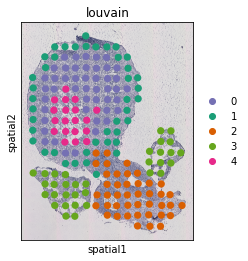

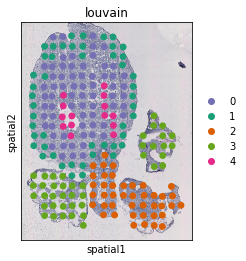

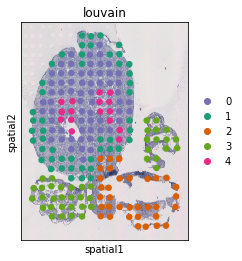

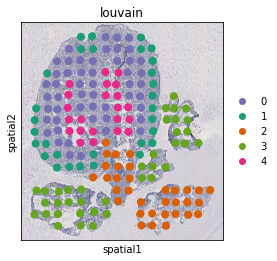

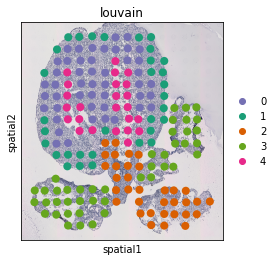

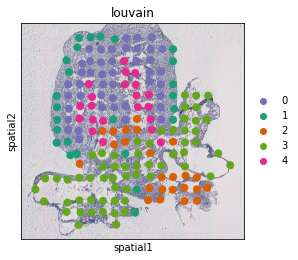

In [13]:
plt.rcParams["figure.figsize"] = (4, 4)
for i, adata_st_i in enumerate(result):
    sc.pl.spatial(result[i], img_key="hires", color=["louvain"], palette=color, size=1.5)